## Running the model CemaneigeGR2M

### Purus Watershed

Dados mensais de:

*  Timestamp
* P (mm) (médias)
* PE (mm) (GLEAM)
* Q (mm) (Estação Fluviométrica)


In [2]:
!gdown 1fYehlZHlnguwPvIo0M_fVK2QuiKGUdV7
!gdown 1kKPYj9mhg-fg2fapBldu5reKqrNC8ma3

Downloading...
From (original): https://drive.google.com/uc?id=1fYehlZHlnguwPvIo0M_fVK2QuiKGUdV7
From (redirected): https://drive.google.com/uc?id=1fYehlZHlnguwPvIo0M_fVK2QuiKGUdV7&confirm=t&uuid=84826851-c133-4430-8f14-688f71f9ae9d
To: /content/gr2m_model.py
100% 11.8k/11.8k [00:00<00:00, 26.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kKPYj9mhg-fg2fapBldu5reKqrNC8ma3
To: /content/dados_bacia_purus_mensais2_2000-2009.csv
100% 9.36k/9.36k [00:00<00:00, 21.2MB/s]


In [3]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

import gr2m_model

In [4]:
df_passado  = pd.read_csv('dados_bacia_purus_mensais2_2000-2009.csv', index_col= 0, sep =',')
df_passado.index=pd.to_datetime(df_passado.index)
area = 243410.3 # km2
# fator de conversao (m_3/s >> mm/dia)
f_conv = (1000 * 24 * 60 * 60)/(area * 1000000)
df_passado['q(mm)'] = df_passado['Streamflow(m3/s)']*f_conv
data = df_passado.copy()
data

,prec_PLUVIO_Thi(mm),Purus PET (mm/d),Streamflow(m3/s),q(mm)
2000-01-31,249.456578,152.983071,281658.910,99.976582
2000-02-29,198.252476,147.653102,307972.320,109.316691
2000-03-31,211.034467,162.413911,346049.220,122.832323
2000-04-30,216.183742,159.067158,340485.836,120.857565
2000-05-31,82.589095,171.227171,331702.104,117.739725
...,...,...,...,...
2009-08-31,15.180340,167.484503,71642.851,25.430076
2009-09-30,61.665433,164.597534,42775.089,15.183284
2009-10-31,99.404852,153.178998,38926.118,13.817068
2009-11-30,191.459830,127.478936,61534.891,21.842192


----------PERIODO AQUECIMENTO, CALIBRACAO E VALIDACAO-------------
Periodo de aquecimento: 2000-01-31 00:00:00-2001-01-31 00:00:00
Periodo de calibracao:  2001-02-28 00:00:00-2007-01-31 00:00:00
Periodo de aqu+calibr:  2000-01-31 00:00:00-2007-01-31 00:00:00
Periodo de validacao:   2007-02-28 00:00:00-2009-12-31 00:00:00


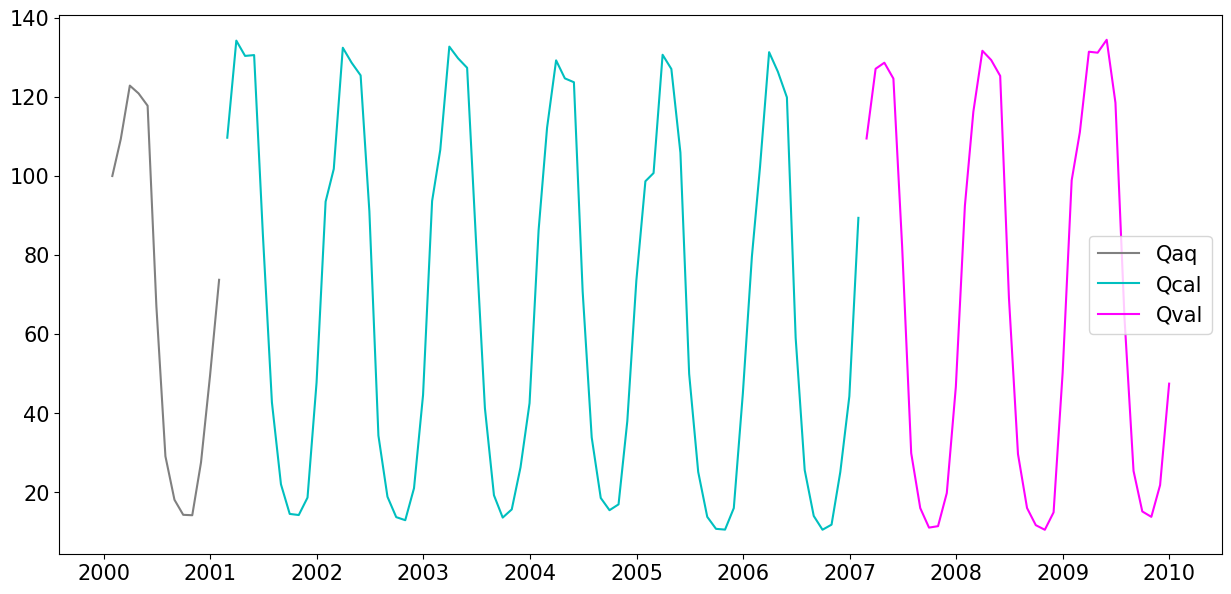

In [5]:
# dados entrada
df = data.copy()

# =========================================================================
print('----------PERIODO AQUECIMENTO, CALIBRACAO E VALIDACAO-------------')
# =========================================================================
# periodo de aquecimento
aq_anos = 1  # anos
end_aq = pd.to_datetime(f"{df.index[0].year + aq_anos}/ {df.index[0].month}/ {df.index[0].day}", yearfirst=True)
h_aq = pd.date_range(end_aq, df.index[0]).shape[0] # dias

# data final da calibracao (2/3)
df2 = df.dropna(subset=['q(mm)'])
df2 = df2[df2.index > end_aq]
#end_cal =  df2.index[round((df2.shape[0]*1)/2)]
end_cal =  df2.index[round((df2.shape[0]*2)/3)]
start_cal = end_aq + pd.DateOffset(months=1)

# periodo de validação inicia um dia depois (1/3)
start_val = end_cal + pd.DateOffset(months=1)
#start_val = '2015-01-01'

# criar periodos
# aquecimento
aq = df[:end_aq]
# calibracao
cal = df[start_cal:end_cal]
# aquecimento mais calibracao
aqcal = df[:end_cal].copy()
# validacao
val = df[start_val:].copy()

# AQUCIMENTO/CALIBRACAO/VALIDACAO -----------------------------------------
print('Periodo de aquecimento: {}-{}'.format(aq.index[0],aq.index[-1]))
print('Periodo de calibracao:  {}-{}'.format(cal.index[0],cal.index[-1]))
print('Periodo de aqu+calibr:  {}-{}'.format(aqcal.index[0],aqcal.index[-1]))
print('Periodo de validacao:   {}-{}'.format(val.index[0],val.index[-1]))

'''Plotar grafico'''
plt.figure(figsize=(15,7))
plt.rcParams.update({'font.size': 15})
plt.plot(df.loc[:end_aq,'q(mm)'], label='Qaq',color='gray')
plt.plot(df.loc[start_cal:end_cal,'q(mm)'], label='Qcal',color='c')
plt.plot(df.loc[start_val:,'q(mm)'], label='Qval',color='magenta')
plt.legend()
#plt.title("Bacia {} ({})".format(nome,bacia))
plt.show()

In [6]:
#fobj = 'logNSE'
fobj = 'NSE'

model = gr2m_model.GR2M()

In [7]:
df.columns

Index(['prec_PLUVIO_Thi(mm)', 'Purus PET (mm/d)', 'Streamflow(m3/s)', 'q(mm)'], dtype='object')

In [8]:

# =========================================================================
print('--------------------------CALIBRANDO-------------------------------')
# =========================================================================

result = model.fit(df['q(mm)'], df['prec_PLUVIO_Thi(mm)'], df['Purus PET (mm/d)']) # ,h_aq=h_aq, fobj = fobj)


--------------------------CALIBRANDO-------------------------------


In [9]:
# obtem os parametros
params = model.get_params(result)
print(result)
print('parametros: ',params)

 message: Optimization terminated successfully.
 success: True
     fun: 0.6337244171909793
       x: [ 2.220e+03  1.095e+00]
     nit: 12
    nfev: 399
     jac: [-1.454e-06  6.994e-07]
parametros:  {'x1': 2220.2414327508855, 'x2': 1.095422190794545}


In [10]:
# =========================================================================
print('--------------------------SIMULANDO-------------------------------')
# =========================================================================
# Descarga simulada
df['Qsim (mm)'] = model.simulate(prec= df['prec_PLUVIO_Thi(mm)'],etp = df['Purus PET (mm/d)'], params=params)

# criar o periodo de calibracao e o periodo de validacao
cal = df[start_cal:end_cal].copy()
val = df[start_val:].copy()

--------------------------SIMULANDO-------------------------------


In [11]:
# criar o periodo de calibracao e o periodo de validacao
cal = df[start_cal:end_cal].copy()
val = df[start_val:].copy()

if fobj == 'logNSE':
    fobj_cal = round(gr2m_model.logNSE(cal['Qsim (mm)'],cal['q(mm)']),4)
    fobj_val = round(gr2m_model.logNSE(val['Qsim (mm)'],val['q(mm)']),4)

elif fobj == 'NSE':
    fobj_cal = round(gr2m_model.NSE(cal['Qsim (mm)'],cal['q(mm)']),4)
    fobj_val = round(gr2m_model.NSE(val['Qsim (mm)'],val['q(mm)']),4)

elif fobj == 'sqrtNSE':
    fobj_cal = round(gr2m_model.sqrtNSE(cal['Qsim (mm)'],cal['q(mm)']),4)
    fobj_val = round(gr2m_model.sqrtNSE(val['Qsim (mm)'],val['q(mm)']),4)

elif fobj == 'mae':
    fobj_cal = round(gr2m_model.calc_mae(cal['Qsim (mm)'],cal['q(mm)']),4)
    fobj_val = round(gr2m_model.calc_mae(val['Qsim (mm)'],val['q(mm)']),4)

print("{} calibracao: {:.4f}".format(fobj,fobj_cal))
print("{} validacao:  {:.4f}".format(fobj,fobj_val))

NSE calibracao: 0.6024
NSE validacao:  0.5220


O coeficiente de Nash-Sutcliffe $\mathrm{NSE}$ é é usado para avaliar a habilidade preditiva de modelos hidrológicos. É definido como:


$$
\mathrm{NSE}=1-\frac{\sum_{t=1}^T\left(Q_o^t-Q_m^t\right)^2}{\sum_{t=1}^T\left(Q_o^t-\bar{Q}_o\right)^2}
$$


Sendo que where $\bar{Q}_o$ é a média da vazão observada, $Q_o$ é a vazão observada e $Q_m$ é a vazão modelada no tempo $t$.

A eficiência de Nash-Sutcliffe é calculada como um menos a razão entre a variância do erro da série temporal modelada dividida pela variância da série temporal observada. Na situação de um modelo perfeito com variância do erro de estimativa igual a zero, a Eficiência Nash-Sutcliffe resultante é igual a 1 (NSE = 1). Por outro lado, um modelo que produz uma variância do erro de estimativa igual à variância da série temporal observada resulta em uma eficiência Nash-Sutcliffe de 0,0 (NSE = 0). Na realidade, NSE = 0 indica que o modelo tem a mesma habilidade preditiva que a média da série temporal em termos da soma do erro quadrático. No caso de uma série temporal modelada com uma variância do erro de estimativa significativamente maior que a variância das observações, o NSE torna-se negativo. Uma eficiência menor que zero (NSE < 0) ocorre quando a média observada é um preditor melhor que o modelo. Valores do NSE mais próximos de 1 sugerem um modelo com maior habilidade preditiva. Para a aplicação do NSE em procedimentos de regressão (ou seja, quando a soma total dos quadrados pode ser particionada em componentes de erro e de regressão), a eficiência de Nash-Sutcliffe é equivalente ao coeficiente de determinação (R2), variando assim entre 0 e 1.

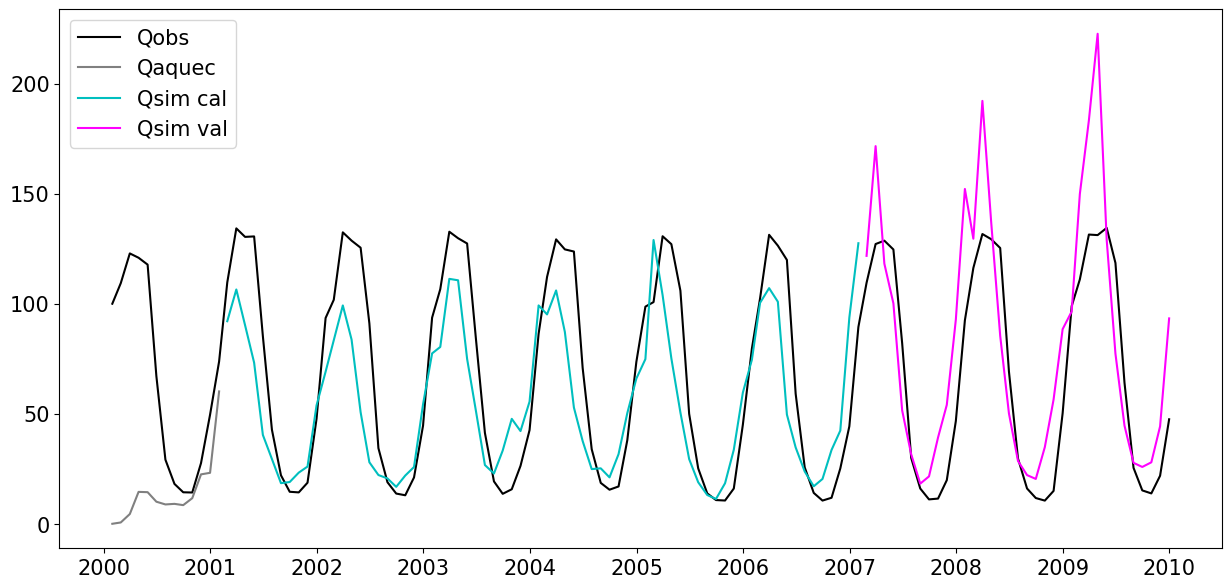

In [12]:
''' Plotar grafico completo '''
plt.figure(figsize=(15,7))
plt.rcParams.update({'font.size': 15})
plt.plot(df.loc[:,'q(mm)'], label='Qobs',color='black')
plt.plot(df.loc[:end_aq,'Qsim (mm)'], label='Qaquec',color='gray' )
plt.plot(df.loc[start_cal:end_cal ,'Qsim (mm)'], label='Qsim cal',color='c')
plt.plot(df.loc[start_val:,'Qsim (mm)'], label='Qsim val',color='magenta')
#plt.title("Bacia {} ({}) \n {} cal =  {:.4f}, {} val = {:.4f}".format(nome,bacia,fobj,fobj_cal,fobj,fobj_val))
plt.legend()
#plt.savefig(dir_figs / "{}.png".format(bacia))
plt.show()